# Marketing analysis: Multi-touch attribution

In [1]:
!pip install pychattr

In [2]:
import pandas as pd
import numpy as np

In [3]:
data = pd.read_csv('mta_data.csv')

In [4]:
data

,path,total_conversions,total_conversion_value,total_null
0,eta > iota > alpha > eta,1,0.244,3
1,iota > iota > iota > iota,2,3.195,6
2,alpha > iota > alpha > alpha > alpha > iota > ...,2,6.754,6
3,beta > eta,1,2.402,3
4,iota > eta > theta > lambda > lambda > theta >...,0,0.000,2
...,...,...,...,...
9995,gamma > alpha > beta > beta,0,0.000,3
9996,beta > lambda,1,3.557,3
9997,iota > theta > iota > iota > iota > iota > iot...,1,2.053,3
9998,eta > beta > beta > eta > eta > beta > eta,1,2.410,3


In [5]:
data['path_steps'] = data.path.apply(lambda x: x[0:].split(' > '))

In [6]:
data.head(2)

,path,total_conversions,total_conversion_value,total_null,path_steps
0,eta > iota > alpha > eta,1,0.244,3,"[eta, iota, alpha, eta]"
1,iota > iota > iota > iota,2,3.195,6,"[iota, iota, iota, iota]"


In [7]:
def get_channels(channel_lists):
    channels = []
    for steps in channel_lists:
        for step in steps:
            if step in channels: pass
            else: channels.append(step) 
    return channels

get_channels(data.path_steps)

['eta',
 'iota',
 'alpha',
 'beta',
 'theta',
 'lambda',
 'kappa',
 'zeta',
 'epsilon',
 'gamma',
 'delta',
 'mi']

<AxesSubplot:>

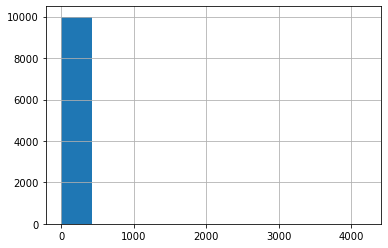

In [8]:
data.total_conversions.hist()

<AxesSubplot:>

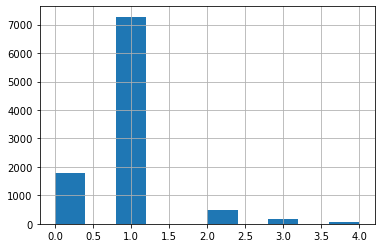

In [9]:
data = data[data['total_conversions'] < 5]
data.total_conversions.hist()

In [10]:
data['total_conversions'].sum()

8943

In [11]:
data['path'].value_counts()

eta                                                                                              570
beta > eta                                                                                       245
eta > eta                                                                                        221
iota > eta                                                                                       144
beta                                                                                             132
                                                                                                ... 
iota > lambda > beta                                                                               1
alpha > iota > iota > alpha > alpha > lambda                                                       1
beta > beta > beta > beta > gamma > beta > beta > beta > alpha > beta > beta > beta > beta         1
eta > beta > eta > alpha > iota > eta                                                      

## Markov Chains

In [12]:
import pychattr
from pychattr.channel_attribution import MarkovModel

In [13]:
from pychattr.channel_attribution import MarkovModel

path_feature="path"
conversion_feature="total_conversions"
null_feature=None
revenue_feature="total_conversion_value"
cost_feature=None
separator=">"
k_order=1
n_simulations=10000
max_steps=None
return_transition_probs=True
random_state=26

# instantiate the model
mm = MarkovModel(path_feature=path_feature,
                 conversion_feature=conversion_feature,
                 null_feature=null_feature,
                 revenue_feature=revenue_feature,
                 cost_feature=cost_feature,
                 separator=separator,
                 k_order=k_order,
                 n_simulations=n_simulations,
                 max_steps=max_steps,
                 return_transition_probs=return_transition_probs,
                 random_state=random_state)

# fit the model
mm.fit(data)

In [14]:
# view the simulation results
print(mm.attribution_model_)

   channel_name  total_conversions  total_revenue
0           eta        1807.850113    7908.155669
1          iota        1715.904683    7465.950481
2         alpha        1272.783062    5684.244695
3          beta        1512.640706    6615.384648
4         theta         957.278007    4173.873998
5        lambda         701.122344    3152.243141
6         kappa         191.271096     867.779822
7          zeta         269.378585    1168.001639
8       epsilon         389.922426    1642.372083
9         gamma         121.158861     646.610819
10        delta           2.767588      10.232374
11           mi           0.922529       2.734575


In [15]:
# view the removal effects
print(mm.removal_effects_)

   channel_name  removal_effect  removal_effect_value
0           eta          0.5879              0.584404
1          iota          0.5580              0.551726
2         alpha          0.4139              0.420060
3          beta          0.4919              0.488870
4         theta          0.3113              0.308445
5        lambda          0.2280              0.232947
6         kappa          0.0622              0.064128
7          zeta          0.0876              0.086314
8       epsilon          0.1268              0.121370
9         gamma          0.0394              0.047784
10        delta          0.0009              0.000756
11           mi          0.0003              0.000202


In [16]:
markov_multi_paths = mm.attribution_model_

In [17]:
markov_multi_paths

,channel_name,total_conversions,total_revenue
0,eta,1807.850113,7908.155669
1,iota,1715.904683,7465.950481
2,alpha,1272.783062,5684.244695
3,beta,1512.640706,6615.384648
4,theta,957.278007,4173.873998
5,lambda,701.122344,3152.243141
6,kappa,191.271096,867.779822
7,zeta,269.378585,1168.001639
8,epsilon,389.922426,1642.372083
9,gamma,121.158861,646.610819


## Shapley

Source: https://www.kaggle.com/code/jasonbrewster/shapley-value-attribution-modeling/notebook

In [18]:
import pandas as pd
import itertools
from collections import defaultdict
from itertools import permutations,combinations
import numpy as np

In [19]:
df_for_shap = data.groupby(['path']).sum().reset_index().drop(['total_null'],axis=1)
df_for_shap = df_for_shap.rename(columns={"path": "channels_subset"})

In [20]:
df_for_shap

,channels_subset,total_conversions,total_conversion_value
0,alpha > alpha > alpha > alpha > alpha > alpha ...,4,8.096000
1,alpha > alpha > alpha > alpha > alpha > alpha ...,4,10.296000
2,alpha > alpha > alpha > alpha > alpha > alpha ...,2,12.649706
3,alpha > alpha > alpha > alpha > alpha > alpha ...,1,11.440000
4,alpha > alpha > alpha > alpha > alpha > alpha ...,1,3.500000
...,...,...,...
5363,zeta > zeta > zeta > iota > beta > iota > iota...,1,3.956000
5364,zeta > zeta > zeta > iota > zeta > zeta > alph...,1,2.300000
5365,zeta > zeta > zeta > lambda > lambda > theta >...,1,5.240000
5366,zeta > zeta > zeta > zeta > iota > zeta > alph...,1,2.400000


Create a function that returns all possible combination of the channel

In [21]:
def power_set(List):
    PS = [list(j) for i in range(len(List)) for j in itertools.combinations(List, i+1)]
    return PS

Return all the possible subsets of a set of channels

In [22]:
def subsets(s):
    '''
    This function returns all the possible subsets of a set of channels.
    input :
            - s: a set of channels.
    '''
    if len(s)==1:
        return s
    else:
        sub_channels=[]
        for i in range(1,len(s)+1):
            sub_channels.extend(map(list,itertools.combinations(s, i)))
    return list(map(",".join,map(sorted,sub_channels)))

Computes the worth of each coalition.

In [23]:
def v_function(A,C_values):
    '''
    This function computes the worth of each coalition.
    inputs:
            - A : a coalition of channels.
            - C_values : A dictionnary containing the number of conversions that each subset of channels has yielded.
    '''
    subsets_of_A = subsets(A)
    #print(subsets_of_A)
    #exit()
    worth_of_A=0
    for subset in subsets_of_A:
        #print("subset:", subset)
        if subset in C_values:
            #print("subset:", subset, "; Value:", C_values[subset])
            worth_of_A += C_values[subset]
    return worth_of_A

Calculate the factorial of a number (a non-negative integer)

In [24]:
def factorial(n):
    if n == 0:
        return 1
    else:
        return n * factorial(n-1)

Get all the channels

In [25]:
def get_channels(channel_lists):
    channels = []
    for steps in channel_lists:
        for step in steps:
            if step in channels: pass
            else: channels.append(step) 
    return channels

In [26]:
def calculate_shapley(df, col_name, channel_list = None):
    '''
    This function returns the shapley values
            - df: A dataframe with the two columns: ['channels_subset', 'conversion_sum'].
            The channel_subset column is the channel(s) associated with the conversion and the count is the sum of the conversions. 
            - col_name: A string that is the name of the column with conversions
            **Make sure that that each value in channel_subset is in alphabetical order. Email,PPC and PPC,Email are the same 
            in regards to this analysis and should be combined under Email,PPC.
            ***Be careful with the distinct number of channels because this can signifcantly slow the perfomance of this function.
            Remember the total possible combinations of channels is 2^(n) where n is the number of channels. If you have 30 channels
            this is 1,073,741,824 combinations. 
            
    '''
    
    '''
    ### This function does not see all the channels because looks only for "singles"
    ### In this dataset 6 channels out of 12 are not listed as "single" i.e. no user paths
    ### in which this channel would be alone. I provided (below) solution that fixes that
    '''
 
    if channel_list == None: 
        #questionable part
        df['channels'] = df['channels_subset'].apply(lambda x: x if len(x.split(">")) == 1 else np.nan) #here's the delimiter
        channels = list(df['channels'].dropna().unique())
        #end of questionable part
    else:
        channels = channel_list
    
    c_values = df.set_index("channels_subset").to_dict()[col_name]
    v_values = {}
    for A in power_set(channels):
        v_values[','.join(sorted(A))] = v_function(A,c_values)
    #print(v_values)
    n=len(channels)
    shapley_values = defaultdict(int)

    for channel in channels:
        for A in v_values.keys():
            #print(A)
            if channel not in A.split(","):
                #print(channel)
                cardinal_A=len(A.split(","))
                A_with_channel = A.split(",")
                A_with_channel.append(channel)            
                A_with_channel=",".join(sorted(A_with_channel))
                # Weight = |S|!(n-|S|-1)!/n!
                weight = (factorial(cardinal_A)*factorial(n-cardinal_A-1)/factorial(n))
                # Marginal contribution = v(S U {i})-v(S)
                contrib = (v_values[A_with_channel]-v_values[A]) 
                shapley_values[channel] += weight * contrib
        # Add the term corresponding to the empty set
        shapley_values[channel]+= v_values[channel]/n 
        #print('finished channel ',channel)
        
    return shapley_values

In [27]:
def visualize (data, col_name, channel_list = None):
    import matplotlib.pyplot as plt
    from pandas.plotting import scatter_matrix
    %matplotlib inline
    import seaborn as sns
    result = pd.DataFrame(list(dict(calculate_shapley(data, col_name, channel_list)).items()),columns = ['Channel','Contributions'])
    # Visualization
    plt.subplots(figsize=(18, 6))
    sns.barplot(x='Channel', y='Contributions', data=result)
    plt.show()

In [28]:
shap = df_for_shap[['channels_subset','total_conversions']]
shap

,channels_subset,total_conversions
0,alpha > alpha > alpha > alpha > alpha > alpha ...,4
1,alpha > alpha > alpha > alpha > alpha > alpha ...,4
2,alpha > alpha > alpha > alpha > alpha > alpha ...,2
3,alpha > alpha > alpha > alpha > alpha > alpha ...,1
4,alpha > alpha > alpha > alpha > alpha > alpha ...,1
...,...,...
5363,zeta > zeta > zeta > iota > beta > iota > iota...,1
5364,zeta > zeta > zeta > iota > zeta > zeta > alph...,1
5365,zeta > zeta > zeta > lambda > lambda > theta >...,1
5366,zeta > zeta > zeta > zeta > iota > zeta > alph...,1


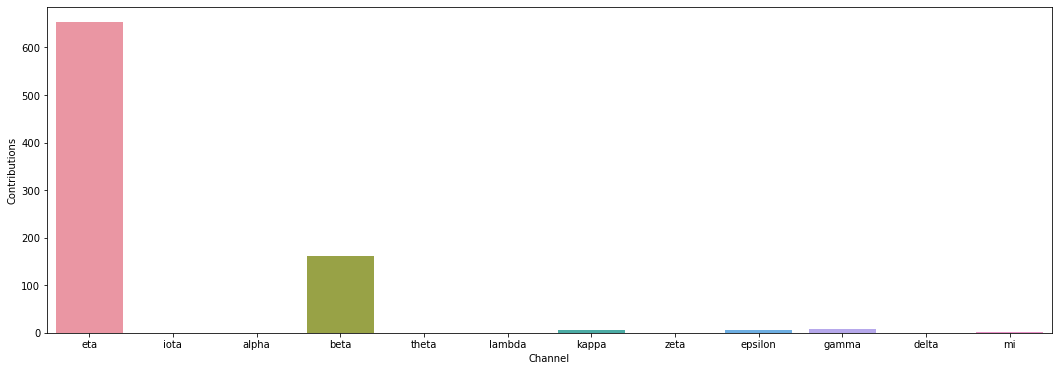

In [29]:
#by total convertion 
visualize(shap,'total_conversions',get_channels(data.path_steps))

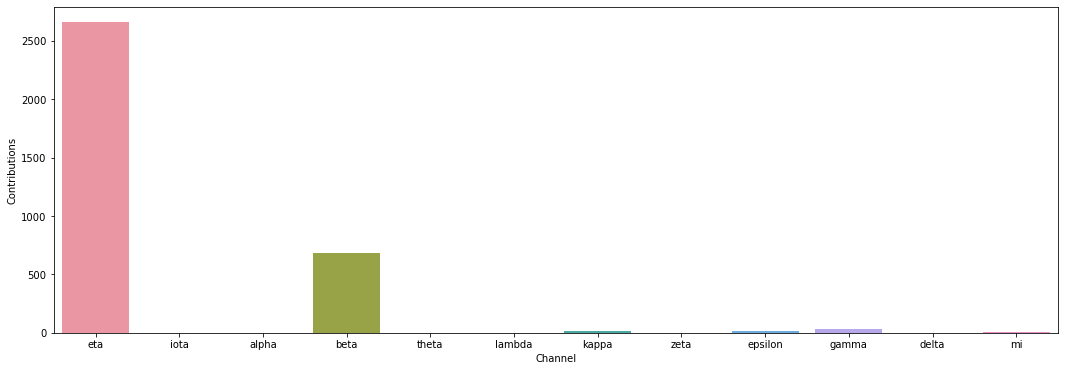

In [30]:
#by total convertion_value
shap = df_for_shap[['channels_subset','total_conversion_value']]
visualize(shap,'total_conversion_value',get_channels(data.path_steps))

## Last Touch Attribution

In [31]:
data['last_channel'] = data.path_steps.apply(lambda x:x[-1])

<ipython-input-31-32aee20d5b63>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['last_channel'] = data.path_steps.apply(lambda x:x[-1])


In [32]:
data.head()

,path,total_conversions,total_conversion_value,total_null,path_steps,last_channel
0,eta > iota > alpha > eta,1,0.244,3,"[eta, iota, alpha, eta]",eta
1,iota > iota > iota > iota,2,3.195,6,"[iota, iota, iota, iota]",iota
2,alpha > iota > alpha > alpha > alpha > iota > ...,2,6.754,6,"[alpha, iota, alpha, alpha, alpha, iota, alpha...",alpha
3,beta > eta,1,2.402,3,"[beta, eta]",eta
4,iota > eta > theta > lambda > lambda > theta >...,0,0.000,2,"[iota, eta, theta, lambda, lambda, theta, lambda]",lambda


In [33]:
channels = get_channels(data.path_steps)
channels

['eta',
 'iota',
 'alpha',
 'beta',
 'theta',
 'lambda',
 'kappa',
 'zeta',
 'epsilon',
 'gamma',
 'delta',
 'mi']

In [34]:
conversions_lt = dict.fromkeys(channels,0)
for index, row in data.iterrows():
    conversions_lt[row['last_channel']]+=1

In [35]:
conversions_lt

{'eta': 3259,
 'iota': 1670,
 'alpha': 1729,
 'beta': 761,
 'theta': 657,
 'lambda': 756,
 'kappa': 252,
 'zeta': 99,
 'epsilon': 523,
 'gamma': 61,
 'delta': 6,
 'mi': 1}

## First Touch Attribution

In [36]:
data['first_channel'] = data.path_steps.apply(lambda x:x[0])

<ipython-input-36-e2273b0e714a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['first_channel'] = data.path_steps.apply(lambda x:x[0])


In [37]:
data.head()

,path,total_conversions,total_conversion_value,total_null,path_steps,last_channel,first_channel
0,eta > iota > alpha > eta,1,0.244,3,"[eta, iota, alpha, eta]",eta,eta
1,iota > iota > iota > iota,2,3.195,6,"[iota, iota, iota, iota]",iota,iota
2,alpha > iota > alpha > alpha > alpha > iota > ...,2,6.754,6,"[alpha, iota, alpha, alpha, alpha, iota, alpha...",alpha,alpha
3,beta > eta,1,2.402,3,"[beta, eta]",eta,beta
4,iota > eta > theta > lambda > lambda > theta >...,0,0.000,2,"[iota, eta, theta, lambda, lambda, theta, lambda]",lambda,iota


In [38]:
conversions_ft = dict.fromkeys(channels,0)
for index, row in data.iterrows():
    conversions_ft[row['first_channel']]+=1

In [39]:
conversions_ft

{'eta': 2148,
 'iota': 3050,
 'alpha': 365,
 'beta': 2610,
 'theta': 842,
 'lambda': 441,
 'kappa': 79,
 'zeta': 31,
 'epsilon': 75,
 'gamma': 131,
 'delta': 1,
 'mi': 1}

In [40]:
ft = pd.DataFrame.from_dict(conversions_ft, orient='index',columns=['First click'])
ft

,First click
eta,2148
iota,3050
alpha,365
beta,2610
theta,842
lambda,441
kappa,79
zeta,31
epsilon,75
gamma,131


In [41]:
lt = pd.DataFrame.from_dict(conversions_lt, orient='index',columns=['Last click'])
lt

,Last click
eta,3259
iota,1670
alpha,1729
beta,761
theta,657
lambda,756
kappa,252
zeta,99
epsilon,523
gamma,61


In [73]:
result = ft.join(lt, how="outer")

In [74]:
result

,First click,Last click
eta,2148,3259
iota,3050,1670
alpha,365,1729
beta,2610,761
theta,842,657
lambda,441,756
kappa,79,252
zeta,31,99
epsilon,75,523
gamma,131,61


In [75]:
shap = df_for_shap[['channels_subset','total_conversion_value']]
shap_res = calculate_shapley(shap,'total_conversion_value',get_channels(data.path_steps))
shap_res = pd.DataFrame.from_dict(shap_res, orient='index',columns=['Shapley'])

markov_res = mm.attribution_model_.set_index('channel_name').drop('total_revenue',axis=1)
markov_res.rename(columns={"total_conversions": "Markov"},inplace=True)

In [76]:
summary = pd.merge(pd.merge(result, shap_res, left_index=True, right_index=True),
          markov_res, left_index=True, right_index=True)

In [77]:
summary

,First click,Last click,Shapley,Markov
eta,2148,3259,2658.221043,1807.850113
iota,3050,1670,0.000000,1715.904683
alpha,365,1729,0.000000,1272.783062
beta,2610,761,682.070267,1512.640706
theta,842,657,0.000000,957.278007
lambda,441,756,0.000000,701.122344
kappa,79,252,15.788750,191.271096
zeta,31,99,0.000000,269.378585
epsilon,75,523,15.784000,389.922426
gamma,131,61,28.248667,121.158861


In [78]:
p = summary.index.values
p

array(['eta', 'iota', 'alpha', 'beta', 'theta', 'lambda', 'kappa', 'zeta',
       'epsilon', 'gamma', 'delta', 'mi'], dtype=object)

In [79]:
summary.insert( 0, column="Channel",value = p)
summary

,Channel,First click,Last click,Shapley,Markov
eta,eta,2148,3259,2658.221043,1807.850113
iota,iota,3050,1670,0.000000,1715.904683
alpha,alpha,365,1729,0.000000,1272.783062
beta,beta,2610,761,682.070267,1512.640706
theta,theta,842,657,0.000000,957.278007
lambda,lambda,441,756,0.000000,701.122344
kappa,kappa,79,252,15.788750,191.271096
zeta,zeta,31,99,0.000000,269.378585
epsilon,epsilon,75,523,15.784000,389.922426
gamma,gamma,131,61,28.248667,121.158861


In [80]:
summary.reset_index(drop=True, inplace=True)
summary

,Channel,First click,Last click,Shapley,Markov
0,eta,2148,3259,2658.221043,1807.850113
1,iota,3050,1670,0.000000,1715.904683
2,alpha,365,1729,0.000000,1272.783062
3,beta,2610,761,682.070267,1512.640706
4,theta,842,657,0.000000,957.278007
5,lambda,441,756,0.000000,701.122344
6,kappa,79,252,15.788750,191.271096
7,zeta,31,99,0.000000,269.378585
8,epsilon,75,523,15.784000,389.922426
9,gamma,131,61,28.248667,121.158861


In [81]:
summary.to_csv("MTA")